<a href="https://colab.research.google.com/github/Anik85/Anik85/blob/main/vgg16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d erhmrai/ecg-image-data

ecg-image-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/ecg-image-data.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Activation , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.vgg16 import preprocess_input,VGG16
from glob import glob

In [ ]:
train_dir = Path('/content/ECG_Image_data/train')
test_dir = Path('/content/ECG_Image_data/test')

In [ ]:
filepaths = list(train_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))


filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe = pd.concat([filepaths , labels] , axis=1)
dataframe

,Filepath,Label
0,/content/ECG_Image_data/train/M/M5210.png,M
1,/content/ECG_Image_data/train/M/M7844.png,M
2,/content/ECG_Image_data/train/M/M10434.png,M
3,/content/ECG_Image_data/train/M/M5844.png,M
4,/content/ECG_Image_data/train/M/M7139.png,M
...,...,...
99194,/content/ECG_Image_data/train/S/S967.png,S
99195,/content/ECG_Image_data/train/S/S1510.png,S
99196,/content/ECG_Image_data/train/S/S2101.png,S
99197,/content/ECG_Image_data/train/S/S2777.png,S


In [ ]:
dataframe['Label'].value_counts()


N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: Label, dtype: int64

In [ ]:
train_samples = []
for category in dataframe['Label'].unique():
    train_category = dataframe.query("Label == @category")
    train_samples.append(train_category.sample(640, random_state=1))

dataframe_train = pd.concat(train_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

M    640
V    640
Q    640
S    640
F    640
N    640
Name: Label, dtype: int64

In [ ]:
dataframe_train

,Filepath,Label
0,/content/ECG_Image_data/train/M/M6823.png,M
1,/content/ECG_Image_data/train/V/V4815.png,V
2,/content/ECG_Image_data/train/Q/Q615.png,Q
3,/content/ECG_Image_data/train/Q/Q6630.png,Q
4,/content/ECG_Image_data/train/S/S1165.png,S
...,...,...
3835,/content/ECG_Image_data/train/Q/Q4469.png,Q
3836,/content/ECG_Image_data/train/F/F777.png,F
3837,/content/ECG_Image_data/train/F/F234.png,F
3838,/content/ECG_Image_data/train/M/M4818.png,M


In [ ]:
filepaths = list(test_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

dataframe_test = pd.concat([filepaths , labels] , axis=1)
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/M/M1805.png,M
1,/content/ECG_Image_data/test/M/M1858.png,M
2,/content/ECG_Image_data/test/M/M746.png,M
3,/content/ECG_Image_data/test/M/M312.png,M
4,/content/ECG_Image_data/test/M/M1128.png,M
...,...,...
24794,/content/ECG_Image_data/test/S/S318.png,S
24795,/content/ECG_Image_data/test/S/S2702.png,S
24796,/content/ECG_Image_data/test/S/S2430.png,S
24797,/content/ECG_Image_data/test/S/S878.png,S


In [ ]:
dataframe_test['Label'].value_counts()

N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: Label, dtype: int64

In [ ]:
test_samples = []
for category in dataframe_test['Label'].unique():
    test_category = dataframe_test.query("Label == @category")
    test_samples.append(test_category.sample(160, random_state=1))

dataframe_test = pd.concat(test_samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

F    160
S    160
V    160
M    160
N    160
Q    160
Name: Label, dtype: int64

In [ ]:
dataframe_test

,Filepath,Label
0,/content/ECG_Image_data/test/F/F19.png,F
1,/content/ECG_Image_data/test/S/S2556.png,S
2,/content/ECG_Image_data/test/V/V6170.png,V
3,/content/ECG_Image_data/test/V/V5634.png,V
4,/content/ECG_Image_data/test/V/V28.png,V
...,...,...
955,/content/ECG_Image_data/test/Q/Q3767.png,Q
956,/content/ECG_Image_data/test/M/M1132.png,M
957,/content/ECG_Image_data/test/S/S994.png,S
958,/content/ECG_Image_data/test/F/F447.png,F


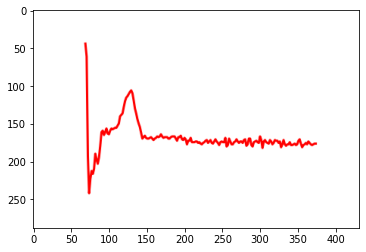

In [ ]:
from keras.utils import img_to_array,load_img
img = load_img(dataframe_test['Filepath'].values[1])
plt.imshow(img)
plt.axis("on")
plt.show()

In [ ]:
#array_image = img_to_array(img)
#print(array_image.shape)

In [ ]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255,
    shear_range = 0.2,
    horizontal_flip=True,
    zoom_range = 0.2,
    validation_split=0.2
  
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    #preprocessing_function=tf.keras.applications.vgg16.preprocess_input,
    rescale=1./255
)

In [ ]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.


In [ ]:
test_generator.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

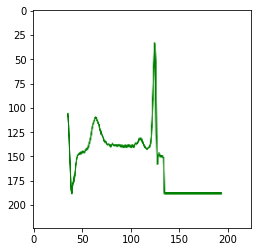

In [ ]:
plt.imshow(test_generator[0][0][3])

In [ ]:
folders=glob('/content/ECG_Image_data/test/*')
folders

['/content/ECG_Image_data/test/M',
 '/content/ECG_Image_data/test/F',
 '/content/ECG_Image_data/test/V',
 '/content/ECG_Image_data/test/N',
 '/content/ECG_Image_data/test/Q',
 '/content/ECG_Image_data/test/S']

In [ ]:
'''pretrained_model = VGG16(
                          input_shape=(224,224,3),
                          include_top= False,
                          weights='imagenet',
                          pooling='avg'
                          )

pretrained_model.trainable = False'''
IMAGE_SIZE = [224, 224]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
'''from tensorflow.keras.layers import *
from tensorflow.keras.models import *

model = Sequential ([
                        pretrained_model,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(6, activation='softmax')
                    ])


model.summary()'''
vgg_model = Model(inputs=vgg.input, outputs=prediction)

vgg_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [ ]:
vgg_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
result=vgg_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
96/96 [==============================] - ETA: 0s - loss: 0.4658 - accuracy: 0.8535
Epoch 1: val_accuracy improved from -inf to 0.98438, saving model to best_model.h5
96/96 [==============================] - 50s 519ms/step - loss: 0.4658 - accuracy: 0.8535 - val_loss: 0.0953 - val_accuracy: 0.9844
Epoch 2/20
96/96 [==============================] - ETA: 0s - loss: 0.0662 - accuracy: 0.9906
Epoch 2: val_accuracy improved from 0.98438 to 0.99219, saving model to best_model.h5
96/96 [==============================] - 50s 518ms/step - loss: 0.0662 - accuracy: 0.9906 - val_loss: 0.0539 - val_accuracy: 0.9922
Epoch 3/20
96/96 [==============================] - ETA: 0s - loss: 0.0367 - accuracy: 0.9964
Epoch 3: val_accuracy improved from 0.99219 to 0.99479, saving model to best_model.h5
96/96 [==============================] - 50s 516ms/step - loss: 0.0367 - accuracy: 0.9964 - val_loss: 0.0353 - val_accuracy: 0.9948
Epoch 4/20
96/96 [==============================] - ETA: 0s - loss:

In [ ]:
vgg_model.save('best.h5')

In [ ]:
from keras.models import load_model
best_model1=load_model('/content/best.h5')
results1 = best_model1.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results1[0]))
print("Test Accuracy: {:.2f}%".format(results1[1] * 100))

    Test Loss: 0.00428
Test Accuracy: 99.90%


In [ ]:
from keras.models import load_model
best_model=load_model('/content/best_model.h5')
results = best_model.evaluate(test_generator, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.00560
Test Accuracy: 99.90%


Text(0, 0.5, 'loss')

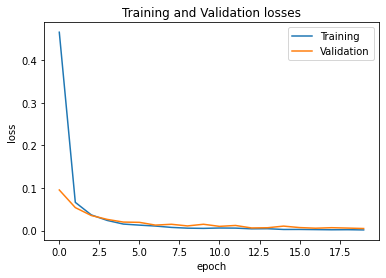

In [ ]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')

Text(0, 0.5, 'accuracy')

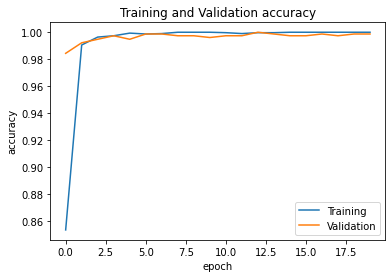

In [ ]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')

In [ ]:
y_pred = best_model1.predict(test_generator)
y_pred

30/30 [==============================] - 5s 176ms/step


array([[9.9999237e-01, 2.3410969e-07, 3.0281501e-06, 8.5280547e-09,
        4.1583930e-06, 2.6745013e-07],
       [1.0862678e-04, 8.2573271e-05, 3.5791803e-05, 3.7699127e-05,
        9.9850899e-01, 1.2262434e-03],
       [1.1011778e-06, 7.4806815e-07, 3.1297903e-05, 1.3648022e-04,
        7.8853884e-07, 9.9982953e-01],
       ...,
       [3.7293757e-05, 8.7278795e-07, 6.4719961e-07, 9.4486255e-05,
        9.9986577e-01, 8.9842774e-07],
       [9.9995065e-01, 4.9932123e-07, 7.4668651e-06, 1.5232548e-07,
        4.0912179e-05, 3.1196433e-07],
       [6.7788312e-07, 9.9989927e-01, 8.6080865e-05, 8.4058374e-06,
        4.8253683e-06, 6.6670617e-07]], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([0, 4, 5, 5, 5, 0, 4, 0, 1, 1, 2, 5, 0, 1, 3, 3, 1, 3, 2, 1, 0, 5,
       3, 1, 3, 3, 0, 5, 1, 2, 5, 0, 1, 5, 1, 5, 0, 2, 0, 2, 4, 2, 0, 5,
       0, 3, 0, 3, 0, 4, 1, 1, 4, 5, 5, 4, 4, 4, 3, 4, 5, 2, 1, 2, 5, 4,
       2, 5, 0, 2, 0, 2, 2, 2, 2, 5, 4, 1, 4, 1, 4, 4, 3, 5, 1, 2, 1, 3,
       2, 2, 3, 2, 4, 0, 3, 1, 3, 0, 3, 1, 2, 1, 3, 2, 5, 3, 0, 4, 0, 3,
       1, 3, 3, 2, 1, 1, 1, 5, 5, 5, 4, 1, 3, 4, 0, 5, 3, 0, 0, 2, 3, 2,
       1, 3, 1, 4, 5, 5, 1, 4, 0, 1, 0, 5, 4, 4, 3, 5, 1, 0, 2, 5, 3, 3,
       0, 1, 0, 5, 2, 5, 5, 2, 2, 5, 3, 0, 3, 4, 5, 4, 2, 3, 0, 0, 4, 2,
       1, 2, 2, 1, 2, 4, 0, 5, 3, 0, 3, 0, 3, 1, 0, 3, 5, 3, 0, 3, 4, 4,
       2, 0, 2, 2, 2, 4, 0, 1, 4, 1, 3, 4, 4, 5, 4, 3, 1, 3, 0, 4, 2, 4,
       2, 4, 5, 1, 0, 1, 4, 2, 1, 3, 0, 1, 3, 4, 2, 1, 2, 2, 3, 0, 5, 1,
       3, 3, 2, 2, 4, 5, 1, 5, 1, 3, 1, 5, 3, 3, 5, 5, 4, 4, 3, 4, 1, 0,
       2, 0, 5, 1, 2, 2, 0, 2, 5, 2, 4, 1, 4, 0, 3, 2, 3, 3, 4, 4, 1, 5,
       5, 1, 4, 2, 3, 5, 0, 1, 0, 4, 0, 4, 2, 1, 5,

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_generator.labels, y_pred)
print(cm)
print('classification report')
print( classification_report(test_generator.labels, y_pred))

[[160   0   0   0   0   0]
 [  0 160   0   0   0   0]
 [  0   0 160   0   0   0]
 [  0   0   0 159   0   1]
 [  0   0   0   0 160   0]
 [  0   0   0   0   0 160]]
classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       160
           1       1.00      1.00      1.00       160
           2       1.00      1.00      1.00       160
           3       1.00      0.99      1.00       160
           4       1.00      1.00      1.00       160
           5       0.99      1.00      1.00       160

    accuracy                           1.00       960
   macro avg       1.00      1.00      1.00       960
weighted avg       1.00      1.00      1.00       960



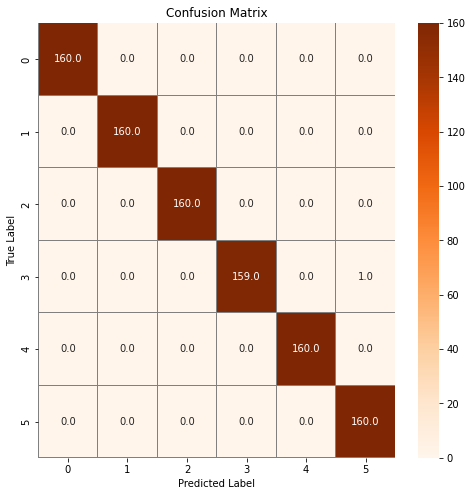

In [ ]:
import seaborn as sns
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(cm, annot=True, linewidths=0.01,cmap="Oranges",linecolor="gray", fmt= '.1f',ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
     

In [ ]:
class_map = dict([(v, k) for k, v in train_generator.class_indices.items()])
print(class_map)

{0: 'F', 1: 'M', 2: 'N', 3: 'Q', 4: 'S', 5: 'V'}


1/1 [==============================] - 0s 16ms/step


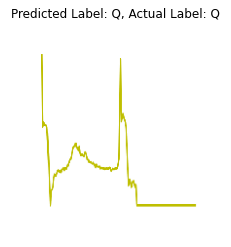

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
test_image_path = '/content/ECG_Image_data/test/Q/Q1072.png'

def generate_predictions(test_image_path, actual_label):
    
    # 1. Load and preprocess the image
    test_img = image.load_img(test_image_path, target_size=(224, 224))
    test_img_arr = image.img_to_array(test_img)/255.0
    test_img_input = test_img_arr.reshape((1, test_img_arr.shape[0], test_img_arr.shape[1], test_img_arr.shape[2]))

    # 2. Make Predictions
    predicted_label = np.argmax(best_model1.predict(test_img_input))
    predicted_beat = class_map[predicted_label]
    plt.figure(figsize=(4, 4))
    plt.imshow(test_img_arr)
    plt.title("Predicted Label: {}, Actual Label: {}".format(predicted_beat, actual_label))
    plt.grid()
    plt.axis('off')
    plt.show()

# call the function
generate_predictions(test_image_path, actual_label='Q')